# Text Recognition with CTC

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [2]:
import ctc_utils as utils
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(utils)

should_retrain = False

In [3]:
img_size = (32, 128)
full_df = pd.read_pickle('../../pickle/df.pickle')
print("Length: ", len(full_df))
df = full_df[['transcription', 'word_img_path', 'word_id']]
df['word_img_path'] = df.word_img_path.apply(lambda x: '../' + x)
df.head(3)

Length:  96420


/var/folders/45/1rh915g935nggkhvq3fhbn180000gn/T/ipykernel_61253/1927137089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_img_path'] = df.word_img_path.apply(lambda x: '../' + x)


transcription                                     word_img_path  \
0             A  ../../data/words/a01/a01-000u/a01-000u-00-00.png   
1          MOVE  ../../data/words/a01/a01-000u/a01-000u-00-01.png   
2            to  ../../data/words/a01/a01-000u/a01-000u-00-02.png   

          word_id  
0  a01-000u-00-00  
1  a01-000u-00-01  
2  a01-000u-00-02

In [4]:
# img = plt.imread(df.iloc[0].word_img_path)
# res = deslant_img(img)


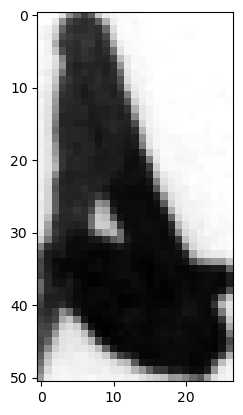

In [5]:
plt.imshow(plt.imread(df.iloc[0].word_img_path), cmap='gray');

In [6]:
import string

char_list = list(string.ascii_letters)+[' '] 

def extract_allowed_chars_from_string(char_list, str):
    res = ''
    for letter in str:
        if letter in char_list:
            res += letter
    return res

df['clean_trans'] = df.transcription.apply(lambda x: extract_allowed_chars_from_string(char_list, x))
df.head()

/var/folders/45/1rh915g935nggkhvq3fhbn180000gn/T/ipykernel_61253/2264966378.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_trans'] = df.transcription.apply(lambda x: extract_allowed_chars_from_string(char_list, x))


transcription                                     word_img_path  \
0             A  ../../data/words/a01/a01-000u/a01-000u-00-00.png   
1          MOVE  ../../data/words/a01/a01-000u/a01-000u-00-01.png   
2            to  ../../data/words/a01/a01-000u/a01-000u-00-02.png   
3          stop  ../../data/words/a01/a01-000u/a01-000u-00-03.png   
4           Mr.  ../../data/words/a01/a01-000u/a01-000u-00-04.png   

          word_id clean_trans  
0  a01-000u-00-00           A  
1  a01-000u-00-01        MOVE  
2  a01-000u-00-02          to  
3  a01-000u-00-03        stop  
4  a01-000u-00-04          Mr

In [7]:
print("Taille avant nettoyage:", len(df))
df = df[(df['clean_trans'] != "") & (df['clean_trans'] == df['transcription'])]
# df = df[df['clean_trans'] != ""]
print("Taille après nettoyage:", len(df))

Taille avant nettoyage: 96420
Taille après nettoyage: 82267


In [8]:
df.transcription.apply(lambda x: len(x)).max()

17

## Pre-process visualization

In [9]:
import random

random_length = 10
row_indexes = random.sample(range(0, len(df)), random_length)
row_indexes

[37506, 35021, 51208, 1725, 74975, 44036, 11817, 10412, 25309, 53731]

2022-11-13 10:05:13.547039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


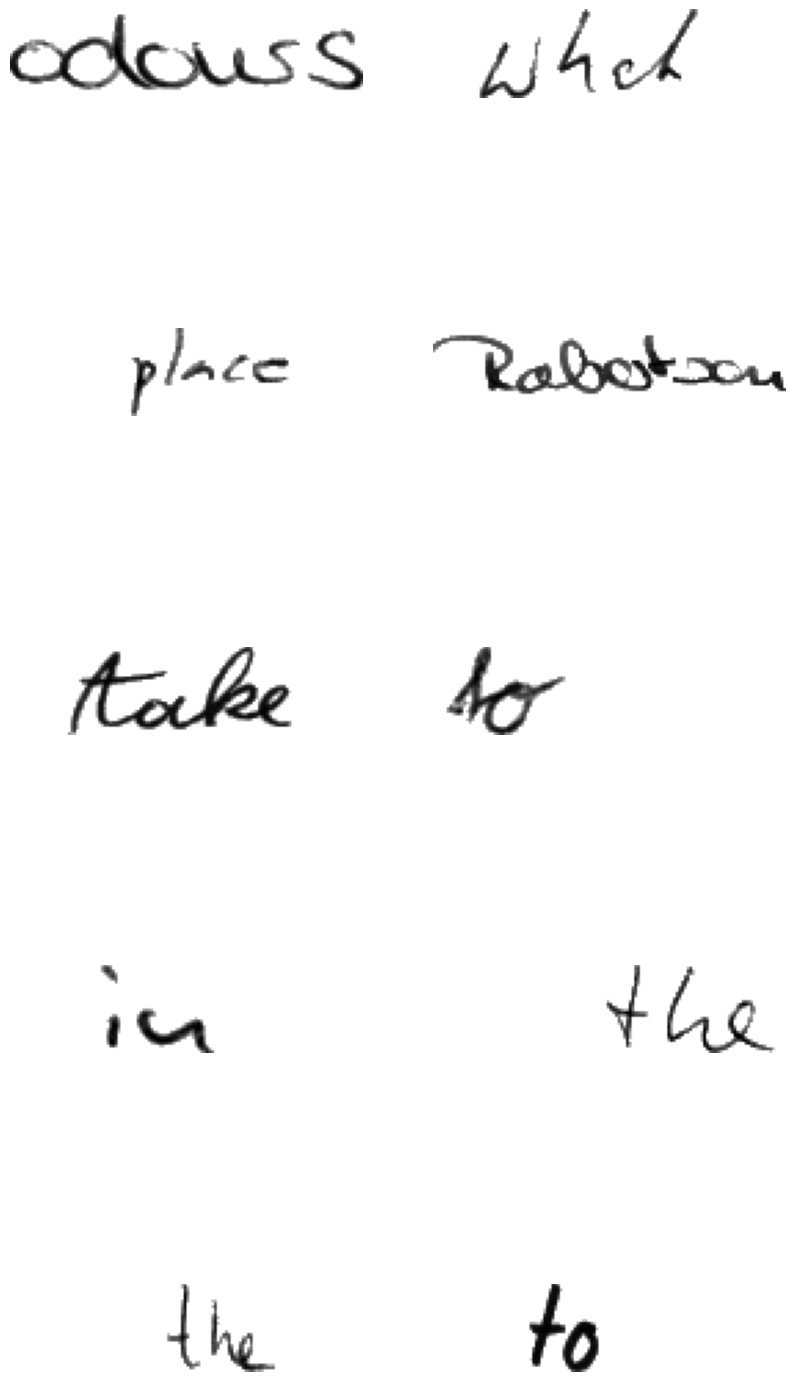

In [10]:
i = 1
reload(utils)

@tf.function
def preprocess_img(word_img_path):
    return utils.preprocess(word_img_path, data_augmentation=True, scale=0.8, is_threshold=True, with_edge_detection=True)


plt.figure(figsize=(10,20))
for index, row in df.iloc[row_indexes].iterrows():
    plt.subplot(random_length // 2, 2, i)
    prepro_img = preprocess_img(row.word_img_path)
    plt.axis('off')
    plt.imshow(prepro_img, cmap='gray')
    i += 1
plt.show()



## Model Doc

### CNN Part


The idea here is to cut our image into several features (could be interpreted as smaller areas of the picture).

<img src="imgs/cnn_result.png" />

To do so, we ill use a succession of 
- **Convolution** to extract
- **Batch Normalization** to prevent our model from overfitting (equivalent of Dropout) 

#### Batch normalization

TLDR: Solve **internal covariate shift** and simplify 

**Normalization** is a procedure to change the value of the numeric variable in the dataset to a typical scale, without misshaping contrasts in the range of value.

**Batch normalization** is a technique for training very deep neural networks that normalizes the contributions to a layer for every mini-batch.

In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does **the distribution of inputs to subsequent layers**.

> We define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training.

These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers.

Batch normalization is a method intended to mitigate internal covariate shift for neural networks.

<img src="imgs/batch_normalization.jpeg" />

This has the impact of settling the learning process and drastically decreasing the number of training epochs required to train deep neural networks.

Sources: 
- https://machinelearning.wtf/terms/internal-covariate-shift/
- https://towardsdatascience.com/batch-normalisation-in-deep-neural-network-ce65dd9e8dbf#:~:text=Batch%20normalization%20solves%20a%20major,you%20can%20often%20remove%20dropout.
- https://towardsdatascience.com/understanding-dataset-shift-f2a5a262a766

#### Conv

<img src="imgs/conv_padding.gif" />

- Padding '**valid**' is the first figure. The filter window stays inside the image. When padding == "VALID", there can be a loss of information. Generally, elements on the right and the bottom of the image tend to be ignored. How many elements are ignored depends on the size of the kernel and the stride.

- Padding '**same**' is the third figure. The output is the same size.


#### Pooling/Flattening

**Pooling** is the process of merging. So it’s basically for the purpose of **reducing the size of the data**.

<img src="imgs/pooling_flattening.png" />

**Flattening** is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector.

Sources: 

- https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480

## Model build

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout

class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)

hidden_layer_count = 256

def build_sequential_model():
    model = tf.keras.Sequential()
    # Layer 1
    # (None, 32, 128, 64)
    model.add(Conv2D(
            filters=32,
            kernel_size=(5,5),
            padding='SAME',
            input_shape = (img_size[0], img_size[1], 1)
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 2
    # (None, 16, 64, 64)
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 3
    # (None, 8, 32, 128 -> nb conv filters)
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))


    # Layer 4
    # (None, 4, 32, 128)
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 5
    # (None, 2, 32, 128)
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
    # (None, 1, 32, 256)
    return model

At this point, we have cut our entry image into X smaller parts. Those parts can be read as a time serie.

Indeed, there is a strong connection between one part and the one coming after by construction (a word is a succession of letters).

We can therefore make use of a **RNN** now in our model.

NB: a part does not correspond exactly to a letter, it is more the idea behind it. It could be interesting to see the importance of the size of each part (number of cuts).


### RNN part

In [12]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda

model_folder_name = "ctc_model_fit_20"

if os.path.isfile(model_folder_name):
    model = tf.keras.models.load_model(model_folder_name, custom_objects={"CTCLoss": CTCLoss})
else:
    model = build_sequential_model()
    model.add(Lambda(lambda x: tf.squeeze(x, axis=1)))
    # (None, 32, 256)
    # Bidirectionnal RNN
    model.add(Bidirectional(GRU(hidden_layer_count, return_sequences=True)))
    model.add(Dense(len(char_list) + 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

```
NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_gru_3/strided_slice:0) to a numpy array.
```



TODO LSTM could be a good idea ? 

https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c
https://distill.pub/2017/ctc/

## Connectionist Temporal Classification

### Encoder/Decoder

In [13]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df.word_img_path, df.clean_trans.values, test_size=0.1, random_state=42)

print(y_train.shape)
print(y_test.shape)
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

(74040,)
(8227,)


In [14]:
@tf.function
def preprocess_entries(x, y):
    return (preprocess_img(x), y)

@tf.function
def preprocess_batch(x_b, y_b):
    return (x_b, utils.encode_labels(y_b, char_list))


dataset_train = dataset_train.map(preprocess_entries).batch(64).map(preprocess_batch)
dataset_test = dataset_test.map(preprocess_entries).batch(64).map(preprocess_batch)

In [15]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

if should_retrain:
    model.compile(loss=CTCLoss(), optimizer=optimizer)
    history = model.fit(
        dataset_train,
        validation_data=dataset_test,
        callbacks=[
            early_stop_callback,
            checkpoint_callback,
        ],
        epochs=20
    )

In [16]:
if not os.path.isfile(model_folder_name):
    model = tf.keras.models.load_model(model_folder_name, custom_objects={"CTCLoss": CTCLoss})

In [17]:
history_pickle_filename = 'history_20.pickle'

if not os.path.isfile(history_pickle_filename):
    with open(history_pickle_filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [18]:
with open(history_pickle_filename, "rb") as file_pi:
    history = pickle.load(file_pi)

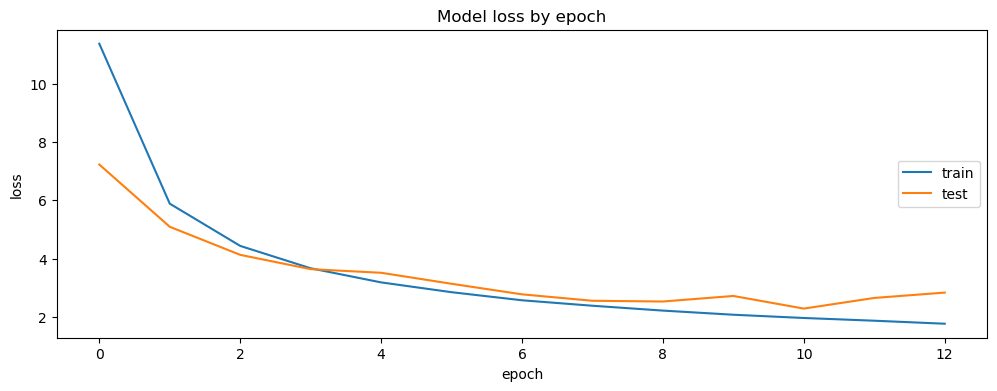

In [19]:
plt.figure(figsize=(12,4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [20]:
y_pred = model.predict(dataset_test)
predicted_transcriptions = utils.greedy_decoder(y_pred, char_list)
list(zip(predicted_transcriptions, y_test[:10]))

129/129 [==============================] - 20s 150ms/step


[('I', 'I'),
 ('his', 'his'),
 ('lRetwven', 'between'),
 ('become', 'become'),
 ('conventional', 'conventional'),
 ('ste', 'she'),
 ('estllihong', 'establishing'),
 ('new', 'new'),
 ('pressue', 'pressure'),
 ('Nater', 'Nato')]

TODO
- Add english language corrector as an option
- See with different slicing (not 32)


In [21]:
if should_retrain:
    model.save('ctc_model_fit_20')


In [22]:
eval_data = list(zip(y_test, predicted_transcriptions, X_test))

In [23]:
eval_df = pd.DataFrame(data=np.array(eval_data), columns=['real', 'predicted', 'word_img_path'])
eval_df.head()

real     predicted  \
0             I             I   
1           his           his   
2       between      lRetwven   
3        become        become   
4  conventional  conventional   

                                      word_img_path  
0    ../../data/words/d06/d06-100/d06-100-01-05.png  
1    ../../data/words/c04/c04-080/c04-080-06-04.png  
2    ../../data/words/g04/g04-017/g04-017-04-11.png  
3    ../../data/words/d07/d07-100/d07-100-06-00.png  
4  ../../data/words/g06/g06-037b/g06-037b-08-03.png

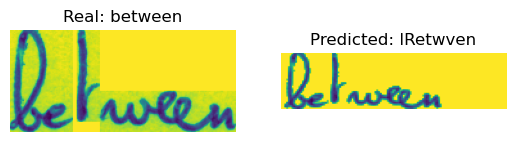

In [33]:
eval_row = eval_df.iloc[2]

def show_eval_img(eval_row):
    img_path = eval_row.word_img_path
    trans_img = preprocess_img(img_path)
    fig, axs = plt.subplots(1, 2)
    [axi.set_axis_off() for axi in axs.ravel()]
    axs[0].imshow(plt.imread(img_path));
    axs[0].set_title("Real: " + eval_row.real);
    axs[1].imshow(trans_img);
    axs[1].set_title("Predicted: " + eval_row.predicted);
    
show_eval_img(eval_row)

In [25]:
len(eval_df)

8227

# Evaluation

https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510

## Character Error Rate (CER)

In [26]:
print(utils.levenshtein_distance("Toto", "Tut"))
print(utils.levenshtein_distance("Bonjour", "Bonnrouuj"))

2
4


In [27]:
eval_df['cer'] = [utils.evaluate_character_level_accuracy(row.real, row.predicted) for index, row in eval_df.iterrows()]

In [28]:
eval_df.head()

real     predicted  \
0             I             I   
1           his           his   
2       between      lRetwven   
3        become        become   
4  conventional  conventional   

                                      word_img_path       cer  
0    ../../data/words/d06/d06-100/d06-100-01-05.png  1.000000  
1    ../../data/words/c04/c04-080/c04-080-06-04.png  1.000000  
2    ../../data/words/g04/g04-017/g04-017-04-11.png  0.571429  
3    ../../data/words/d07/d07-100/d07-100-06-00.png  1.000000  
4  ../../data/words/g06/g06-037b/g06-037b-08-03.png  1.000000

In [29]:
print("Notre modèle a une précision par mot de", eval_df['cer'].mean())

Notre modèle a une précision par mot de 0.8524080672646419


In [30]:
eval_df.describe()

cer
count  8227.000000
mean      0.852408
std       0.217620
min       0.000000
25%       0.750000
50%       1.000000
75%       1.000000
max       1.000000

In [31]:
bad_result_df = eval_df[eval_df['cer'] == 0]
bad_result_df.head()

real predicted                                   word_img_path  cer
275   its      this  ../../data/words/e06/e06-053/e06-053-03-07.png  0.0
285  from     lhoiw  ../../data/words/e04/e04-026/e04-026-01-02.png  0.0
491     A         t  ../../data/words/b05/b05-055/b05-055-00-10.png  0.0
514    do        tr  ../../data/words/b05/b05-042/b05-042-02-04.png  0.0
518    In        la  ../../data/words/a04/a04-027/a04-027-03-06.png  0.0

/var/folders/45/1rh915g935nggkhvq3fhbn180000gn/T/ipykernel_61253/4260598418.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2)


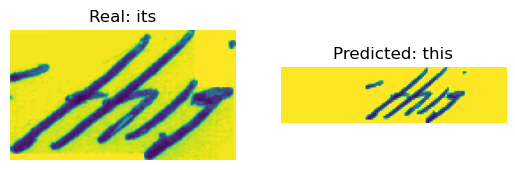

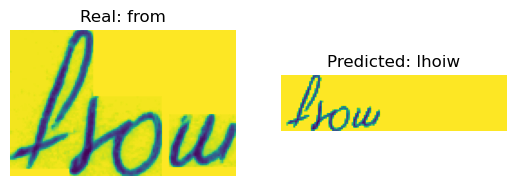

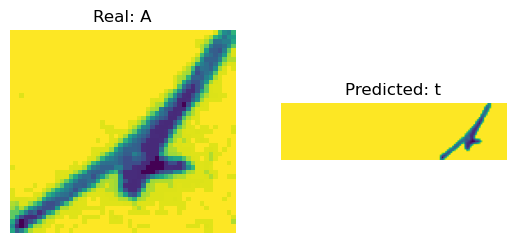

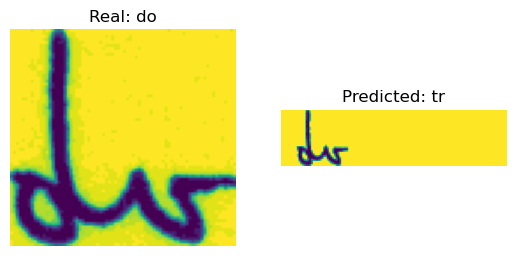

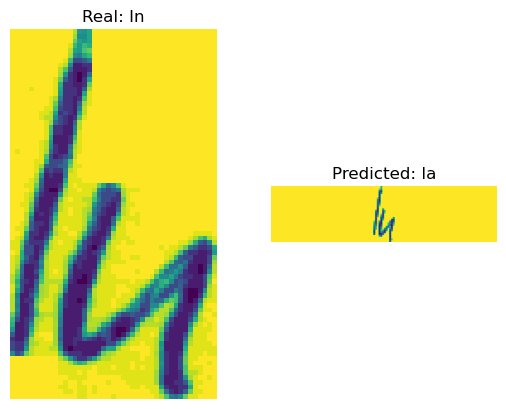

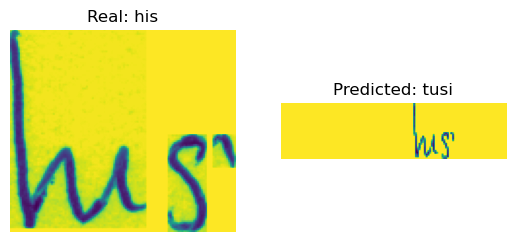

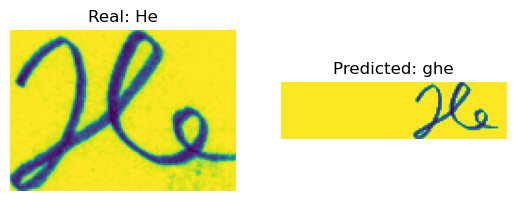

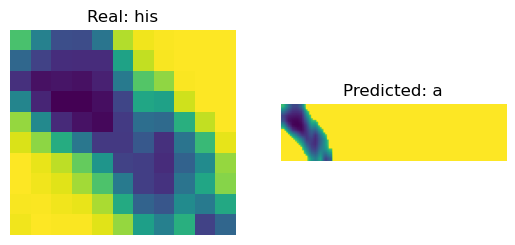

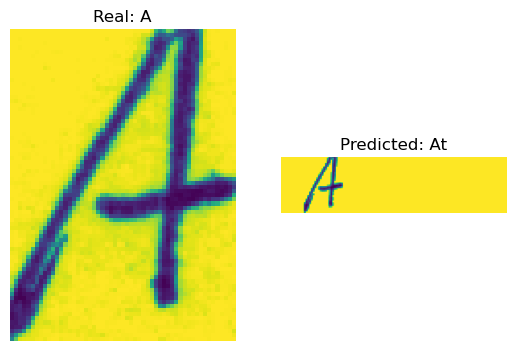

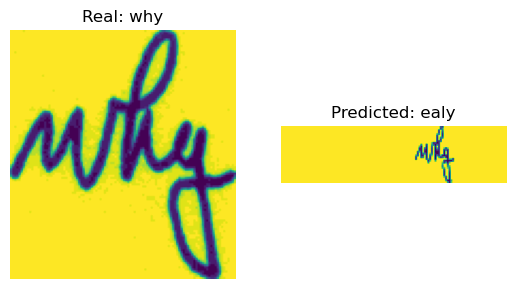

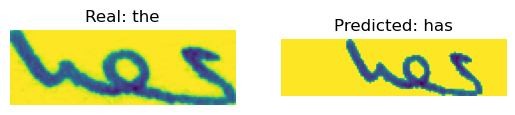

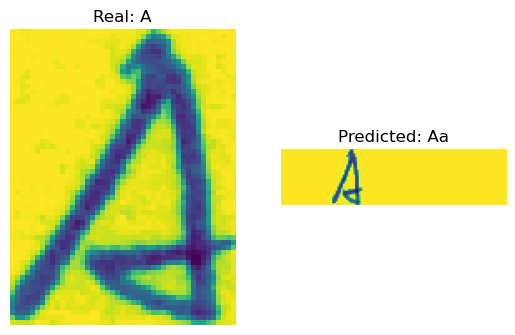

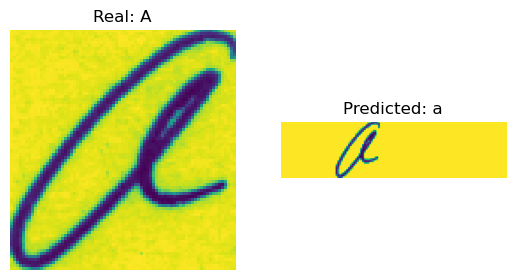

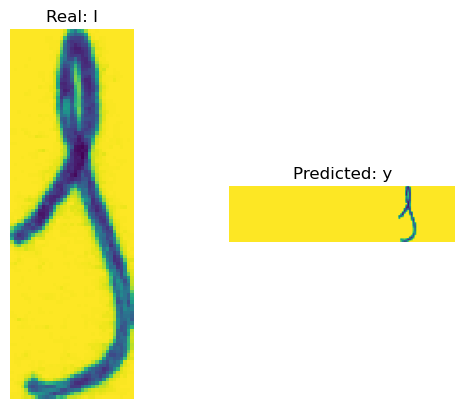

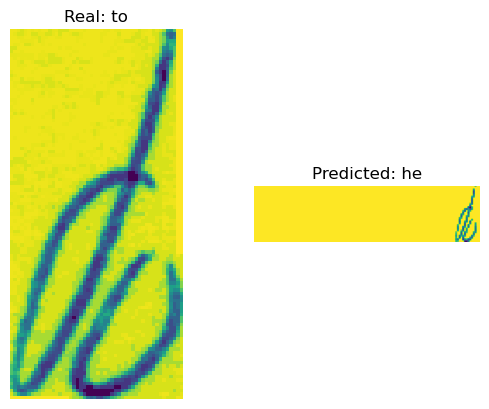

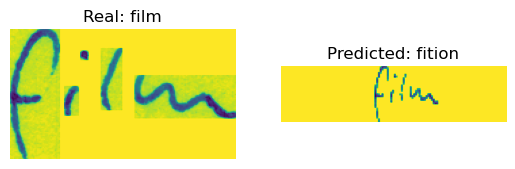

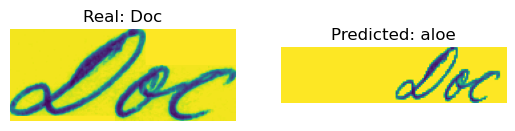

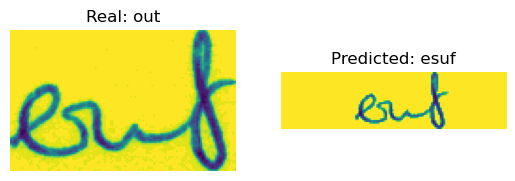

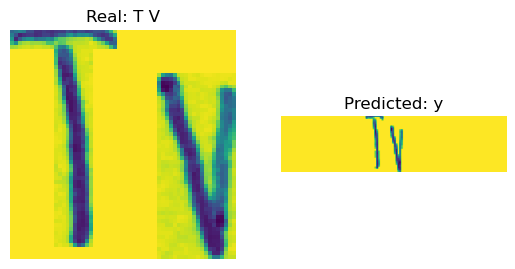

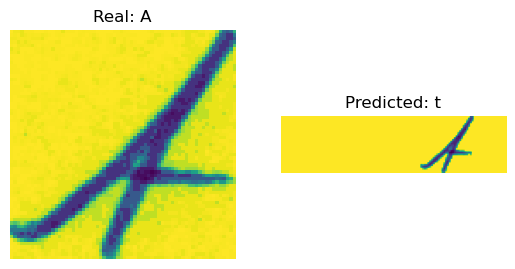

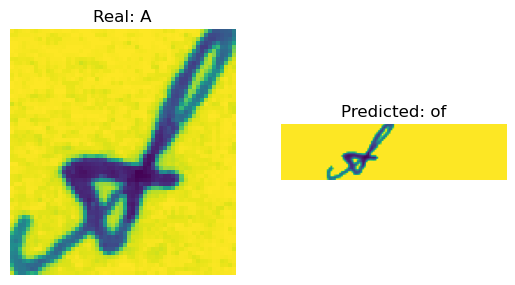

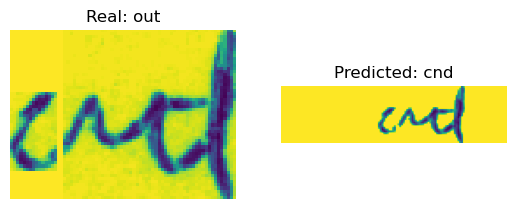

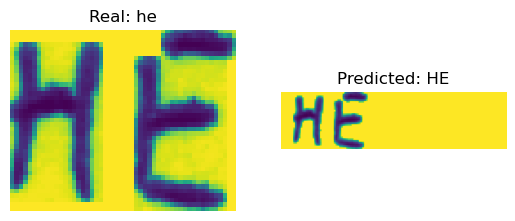

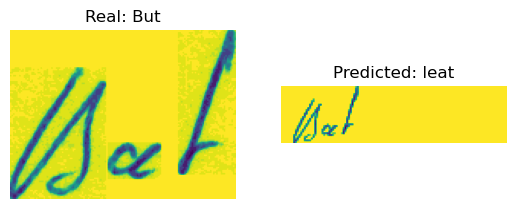

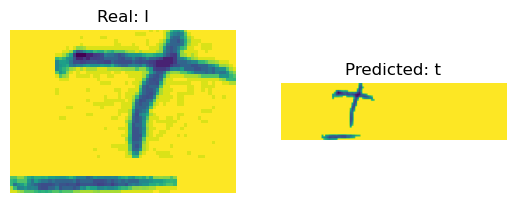

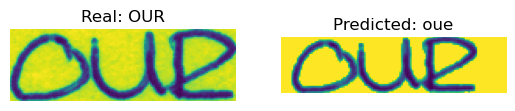

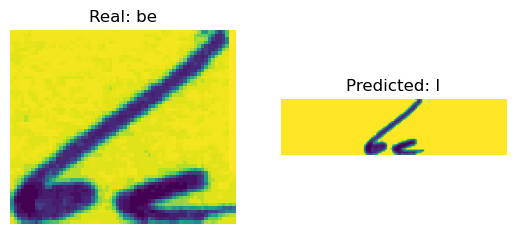

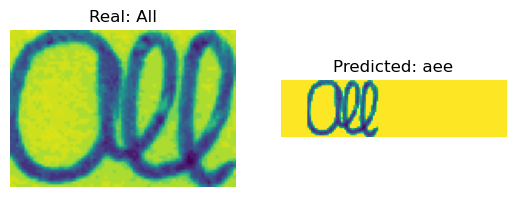

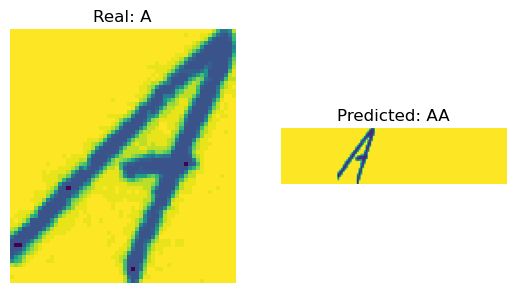

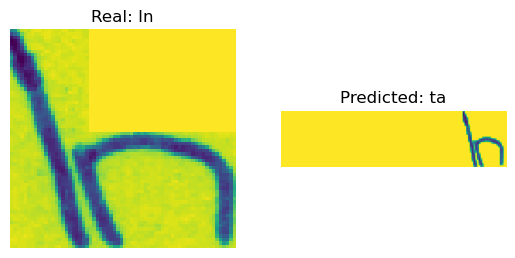

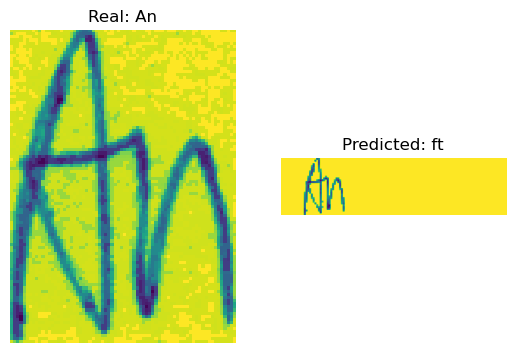

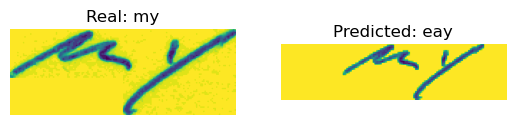

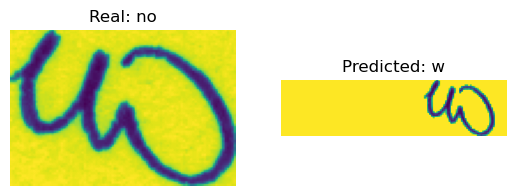

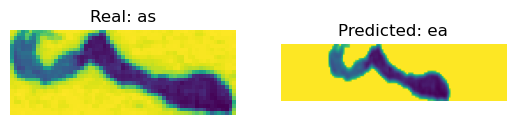

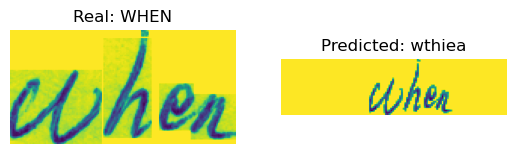

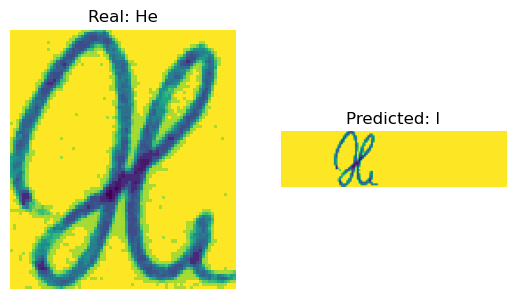

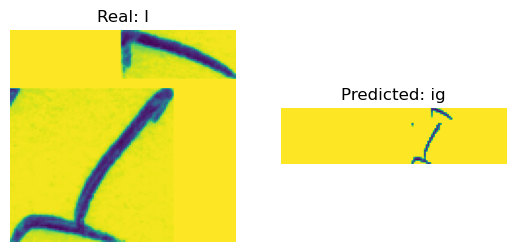

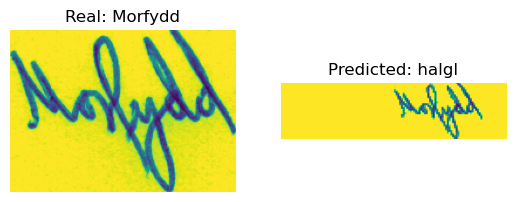

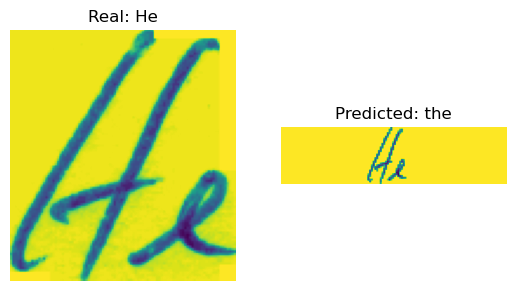

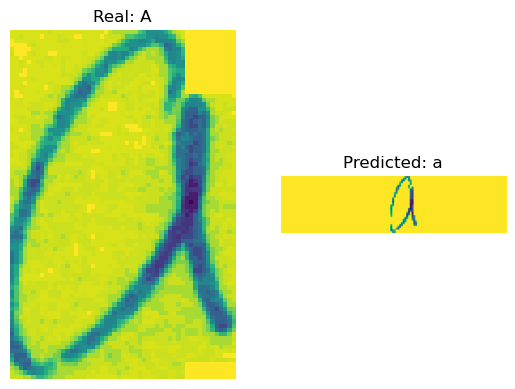

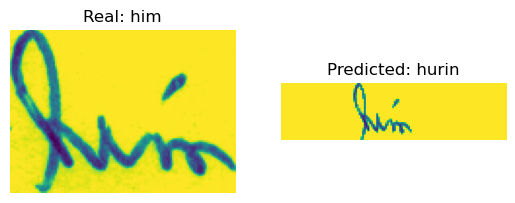

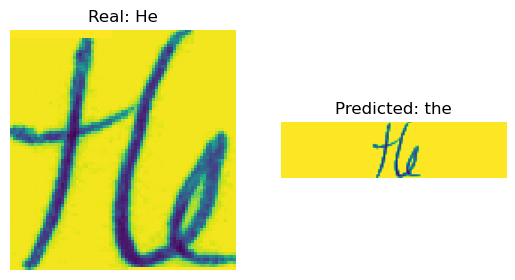

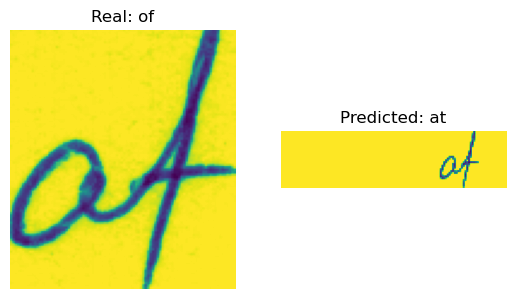

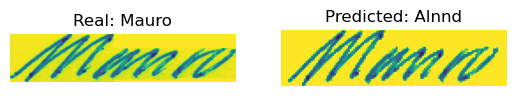

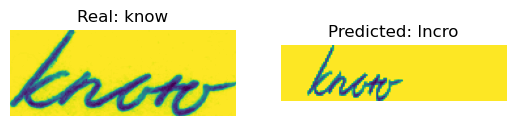

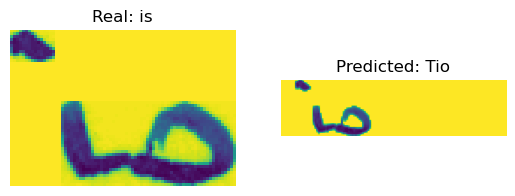

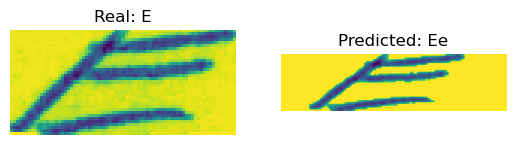

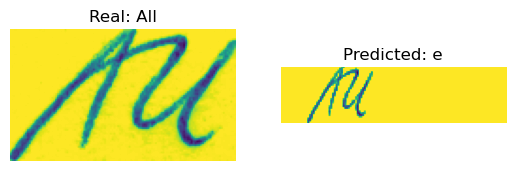

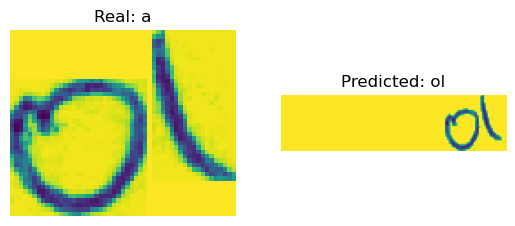

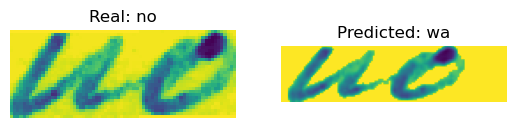

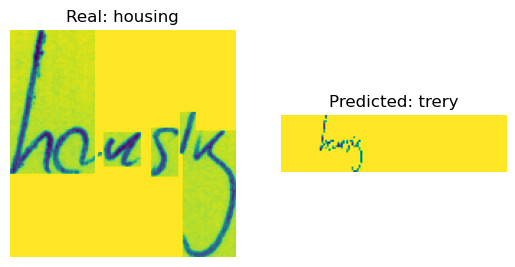

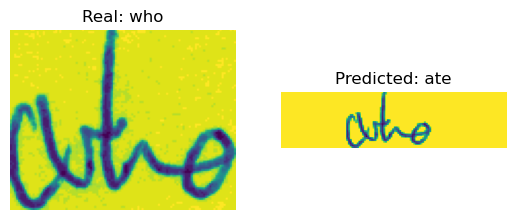

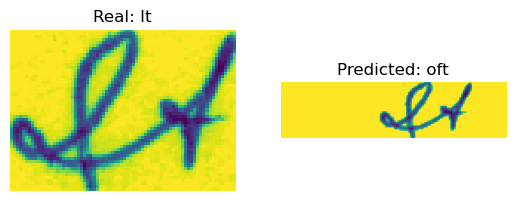

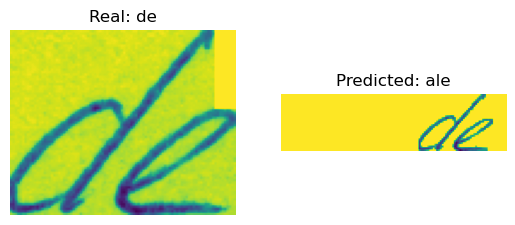

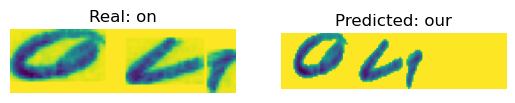

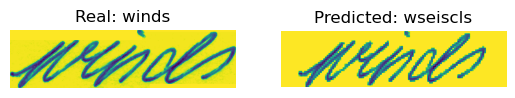

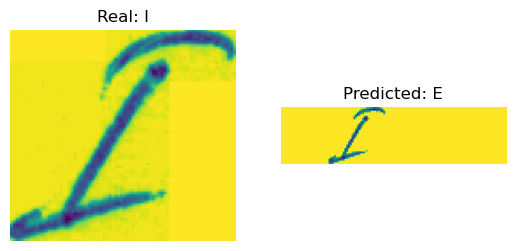

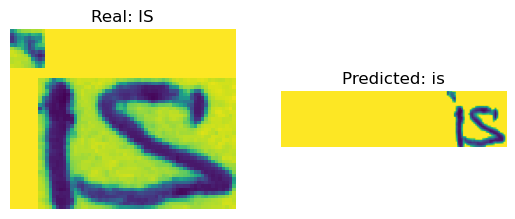

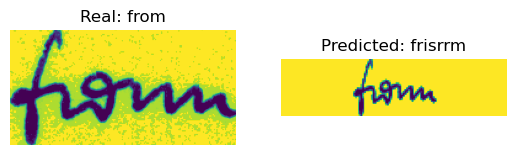

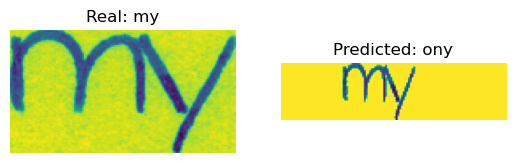

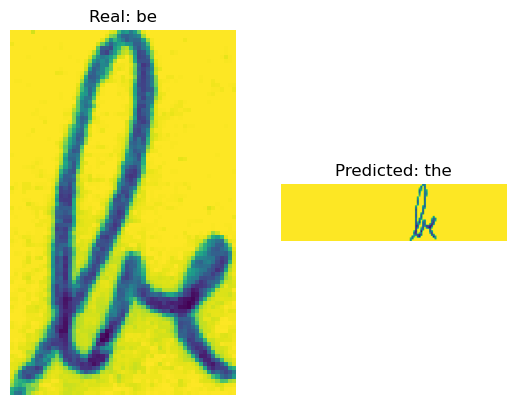

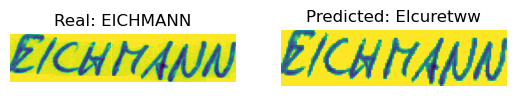

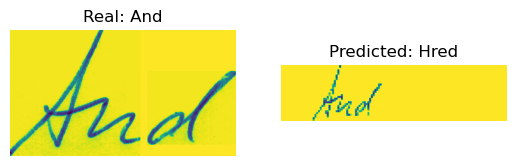

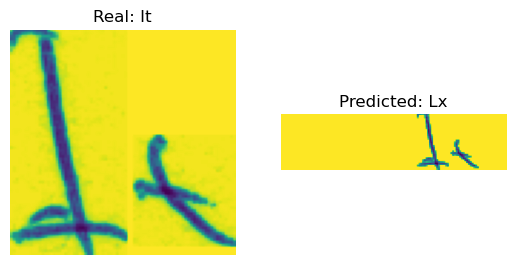

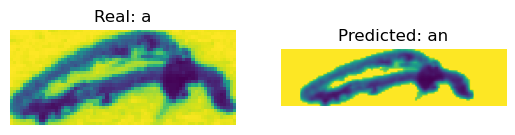

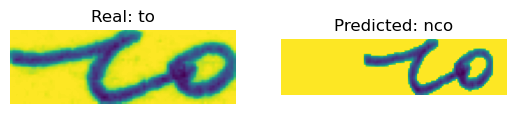

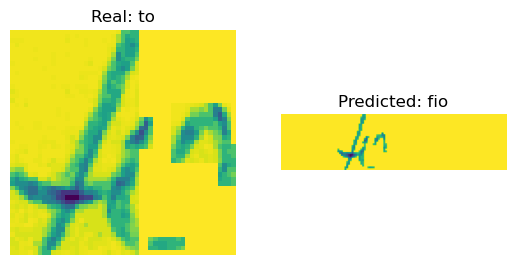

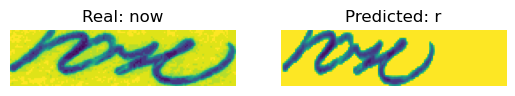

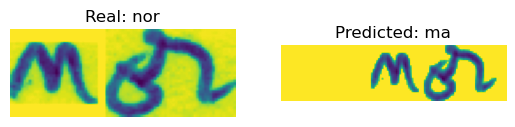

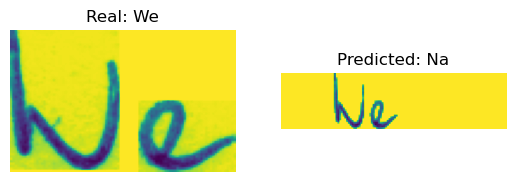

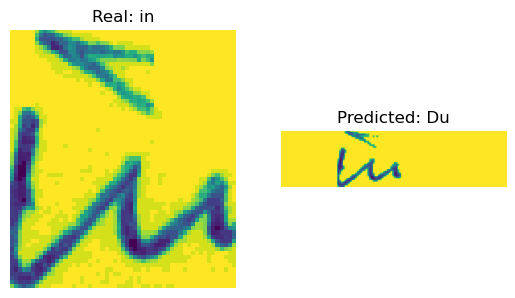

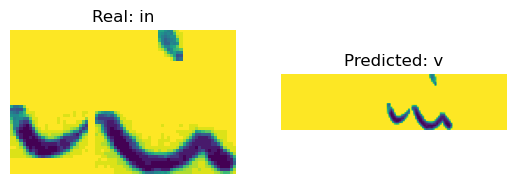

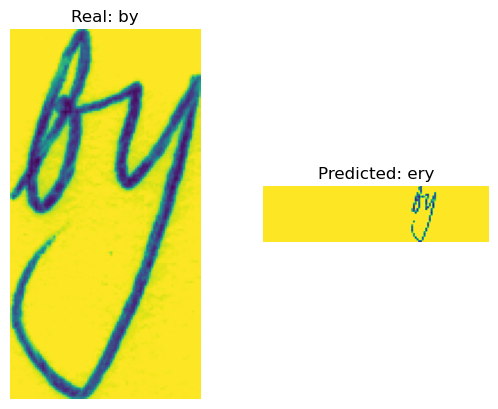

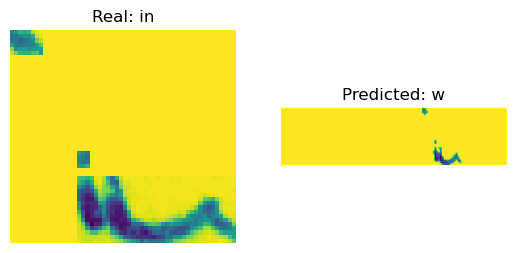

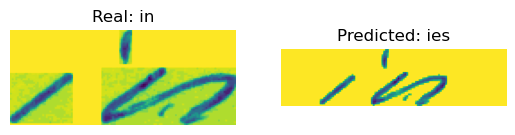

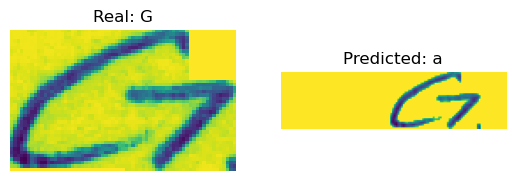

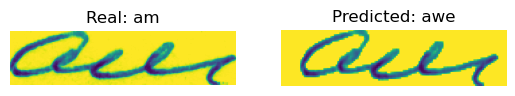

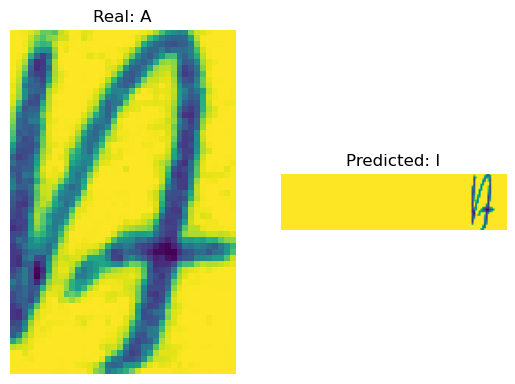

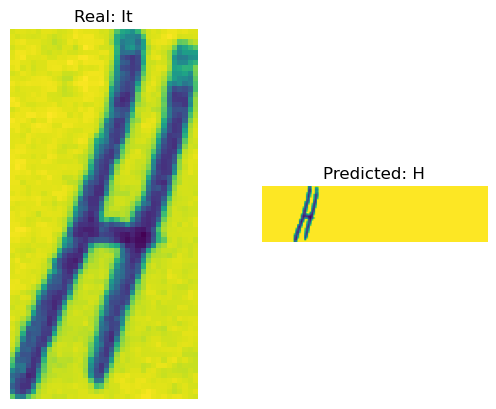

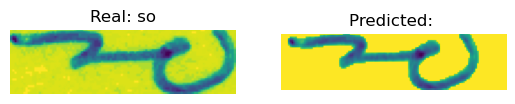

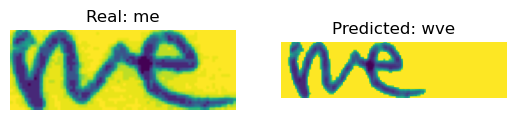

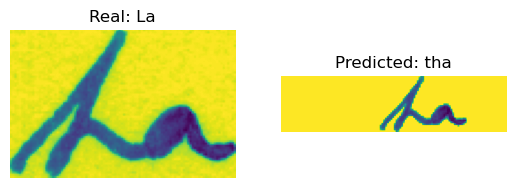

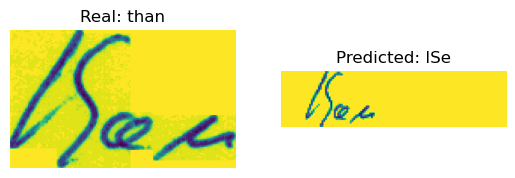

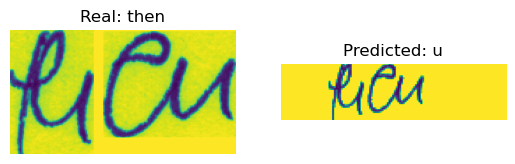

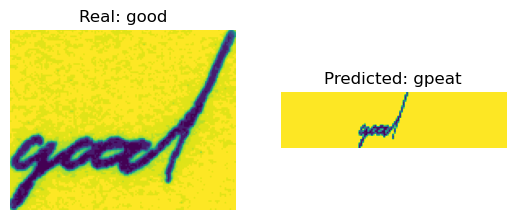

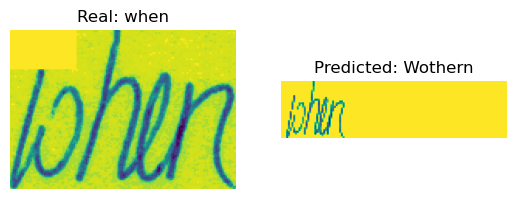

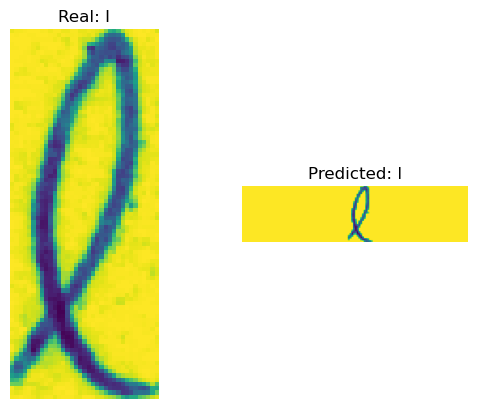

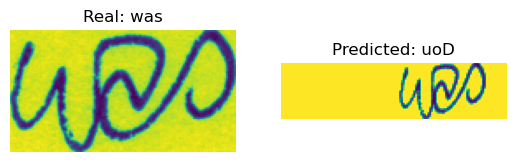

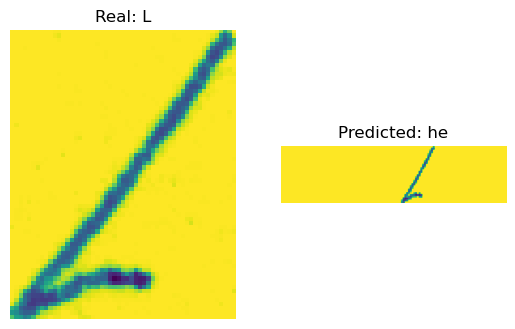

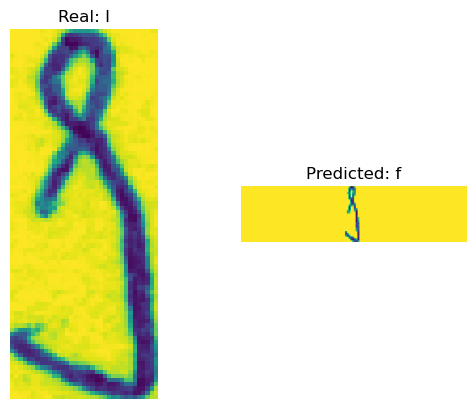

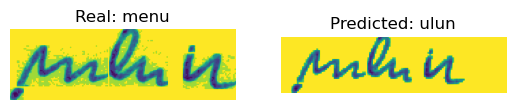

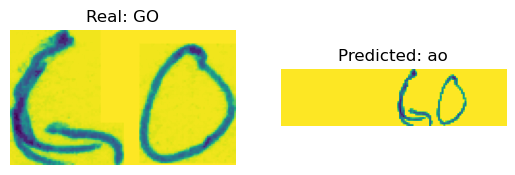

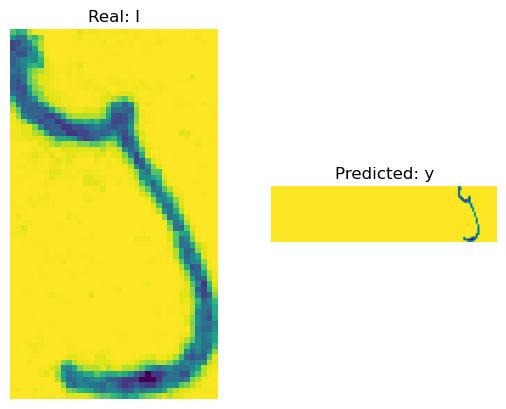

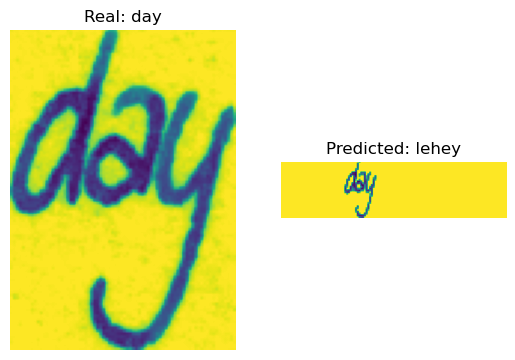

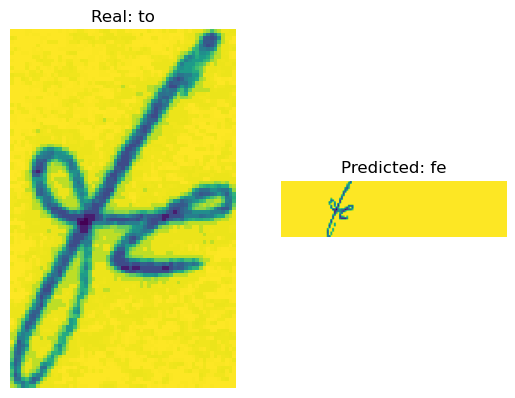

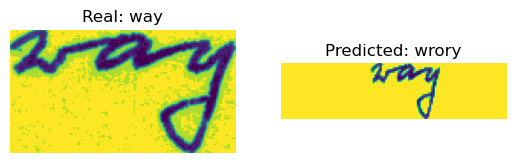

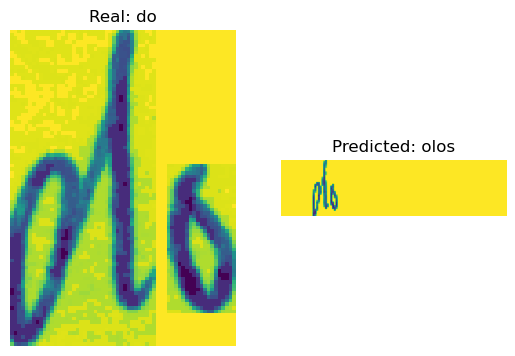

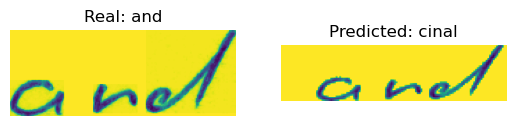

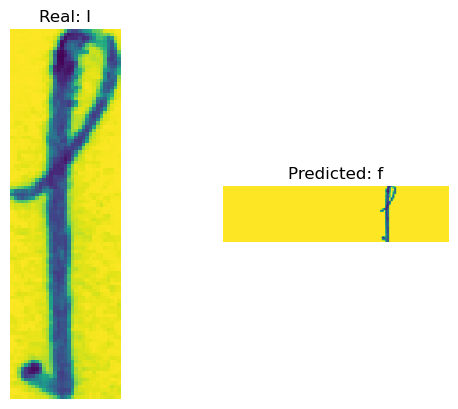

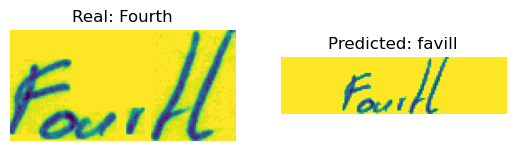

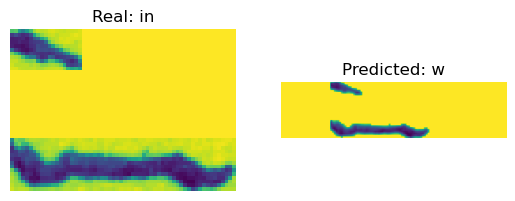

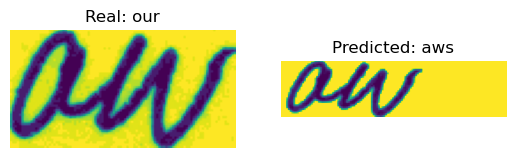

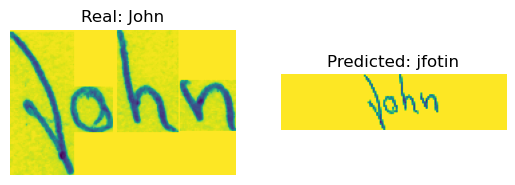

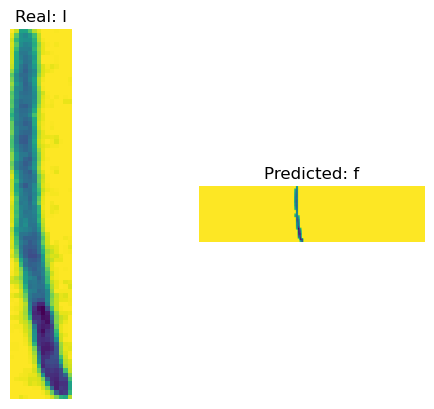

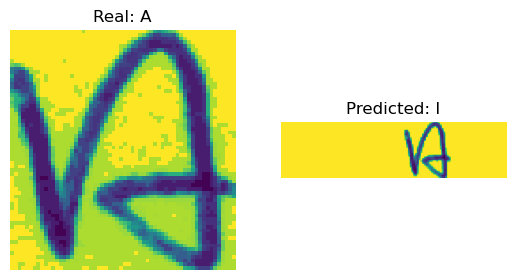

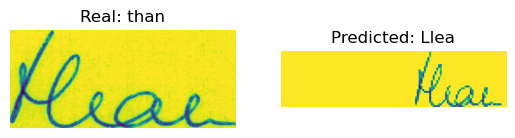

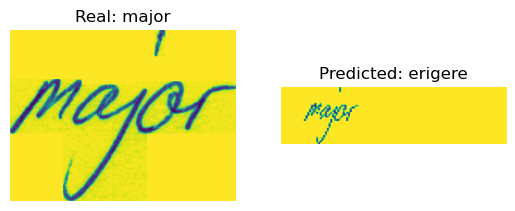

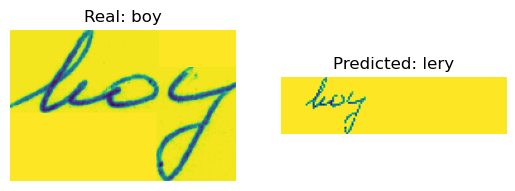

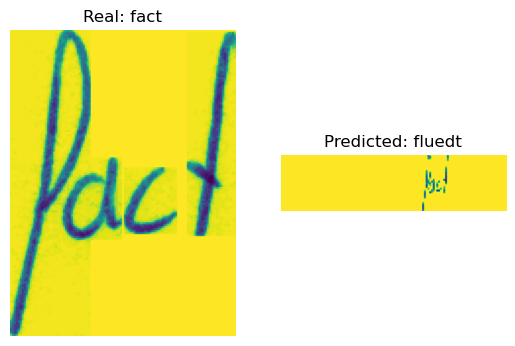

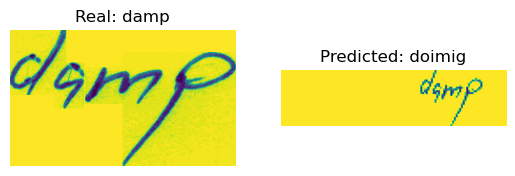

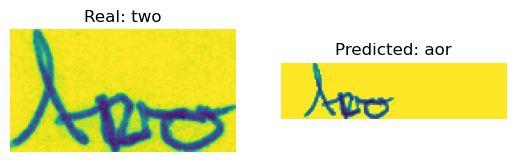

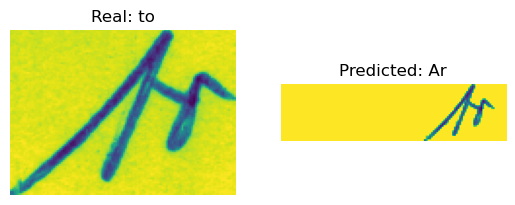

In [34]:
for i in range(max(len(bad_result_df), 6)):
    show_eval_img(bad_result_df.iloc[i])

## Word Error Rate (WER)